In [15]:
%pip install google-cloud-aiplatform pip install scikit-learn matplotlib -q

ERROR: Could not find a version that satisfies the requirement install (from versions: none)
ERROR: No matching distribution found for install
Note: you may need to restart the kernel to use updated packages.


In [2]:
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel

def embed_text() -> list[list[float]]:
    """Embeds texts with a pre-trained, foundational model.

    Returns:
        A list of lists containing the embedding vectors for each input text
    """

    # A list of texts to be embedded.
    texts = ["banana muffins? ", "banana bread? banana muffins?"]
    # The dimensionality of the output embeddings.
    dimensionality = 256
    # The task type for embedding. Check the available tasks in the model's documentation.
    task = "RETRIEVAL_DOCUMENT"

    model = TextEmbeddingModel.from_pretrained("text-embedding-005")
    inputs = [TextEmbeddingInput(text, task) for text in texts]
    kwargs = dict(output_dimensionality=dimensionality) if dimensionality else {}
    embeddings = model.get_embeddings(inputs, **kwargs)

    print(embeddings)
    # Example response:
    # [[0.006135190837085247, -0.01462465338408947, 0.004978656303137541, ...], [0.1234434666, ...]],
    return [embedding.values for embedding in embeddings]


In [2]:
import os
from google.cloud import aiplatform as vertexai
from google.auth.transport.requests import Request


svc_json = "/workspaces/embedding/artefacts/demorag-cc27f388c457.json"
print(os.path.exists(svc_json))


os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = svc_json
# Initialize Vertex AI
vertexai.init(project='demorag')

print(vertexai.Model.list())

True
[]


In [9]:
ret = embed_text()

[TextEmbedding(values=[-0.018134191632270813, -0.004084145650267601, 0.006179547403007746, -0.000177664594957605, 0.01069246232509613, 0.05243939533829689, -0.027185874059796333, 0.015318064950406551, 0.0331207700073719, 0.01388461235910654, -0.05294194445014, -0.033062998205423355, 0.048680271953344345, -0.08813109248876572, 0.03865300491452217, 0.03961200639605522, 0.02718416601419449, -0.04710550606250763, 0.022821953520178795, 0.03019973449409008, 0.0697036162018776, -0.04659046232700348, -0.06744042783975601, 0.02433081716299057, 0.030725259333848953, -0.046980444341897964, -0.05359485000371933, -0.009102667681872845, -0.016856053844094276, 0.04965740069746971, 0.0685722827911377, -0.02209039032459259, -0.011056159622967243, 0.016444789245724678, 0.01304454356431961, -0.04782392829656601, 0.03876301646232605, 0.015563438646495342, 0.010709728114306927, 0.002670983551070094, 0.0011316091986373067, -0.004771558102220297, -0.03718419745564461, -0.04423120245337486, -0.005150150507688

In [9]:
# https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-multimodal-embeddings

from vertexai.vision_models import Image, MultiModalEmbeddingModel
model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding@001")


directory = "/workspaces/embedding/artefacts"
images = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png'))]

embeddings_list = []
keys = []
for image_path in images:
    print(image_path, os.path.exists(image_path))

    image = Image.load_from_file(image_path)
    embeddings = model.get_embeddings(
        image=image,
        contextual_text="Tool",
    )
    embeddings_list.append(embeddings.image_embedding)
    keys.append(os.path.basename(image_path))


/workspaces/embedding/artefacts/g3.jpg True
/workspaces/embedding/artefacts/g1.jpg True
/workspaces/embedding/artefacts/d1.jpg True
/workspaces/embedding/artefacts/b1.jpg True
/workspaces/embedding/artefacts/g2.jpg True
/workspaces/embedding/artefacts/b2.jpg True
/workspaces/embedding/artefacts/d3.jpg True
/workspaces/embedding/artefacts/d2.jpg True
/workspaces/embedding/artefacts/b3.jpg True


In [7]:
len(embeddings_list)
len(embeddings_list[0])

1408

Number of embeddings: 9
Length of each embedding: 1408


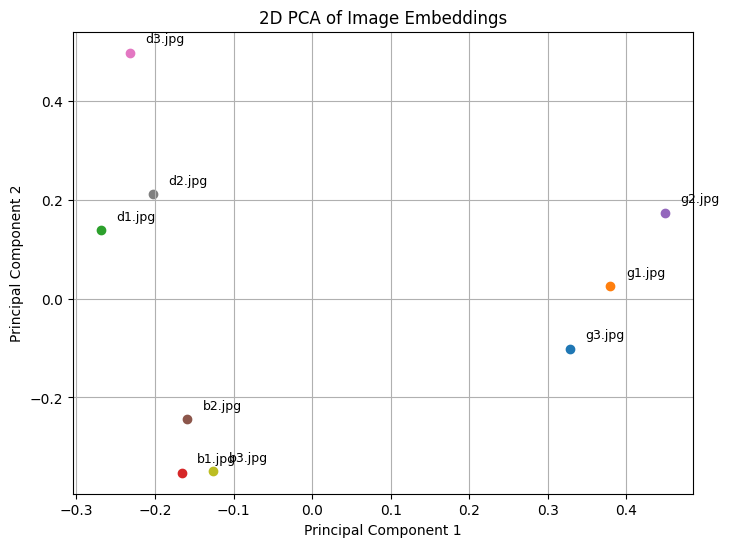

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming `embeddings_list` is already populated and contains arrays of floats
print(f"Number of embeddings: {len(embeddings_list)}")
print(f"Length of each embedding: {len(embeddings_list[0])}")

# Convert embeddings list to a numpy array
embeddings_array = np.array(embeddings_list)

# Perform PCA to reduce to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

# Plot the 2D embeddings
plt.figure(figsize=(8, 6))
for i, (x, y) in enumerate(embeddings_2d):
    plt.scatter(x, y, label=keys[i])
    plt.text(x + 0.02, y + 0.02, keys[i], fontsize=9)  # Label points with index

plt.title("2D PCA of Image Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
#plt.legend()
plt.grid()
plt.show()


In [51]:
import numpy as np
from scipy.spatial.distance import cosine
import pandas as pd


# Number of embeddings
n = len(embeddings_list)

# Initialize a cosine distance matrix
cosine_distance_matrix = np.zeros((n, n))

# Calculate cosine distances
for i in range(n):
    for j in range(n):
        if i != j:  # Avoid redundant calculations or self-comparison
            cosine_distance_matrix[i, j] = cosine(embeddings_list[i], embeddings_list[j])

# Create a DataFrame for better visualization
cosine_distance_table = pd.DataFrame(
    cosine_distance_matrix,
    index=[keys[i] for i in range(n)],
    columns=[keys[i] for i in range(n)]
)

# Print the table
print(cosine_distance_table)


             s1.jpg  s1_1.jpeg    s2.jpg    s3.png    s4.jpg  s1_90.jpg
s1.jpg     0.000000   0.573603  0.460357  0.635906  0.637892   0.142793
s1_1.jpeg  0.573603   0.000000  0.465878  0.701866  0.713519   0.522172
s2.jpg     0.460357   0.465878  0.000000  0.557169  0.571384   0.380526
s3.png     0.635906   0.701866  0.557169  0.000000  0.682261   0.637169
s4.jpg     0.637892   0.713519  0.571384  0.682261  0.000000   0.604078
s1_90.jpg  0.142793   0.522172  0.380526  0.637169  0.604078   0.000000


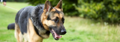

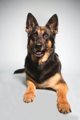

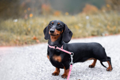

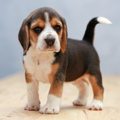

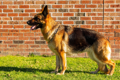

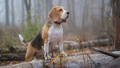

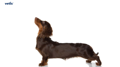

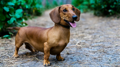

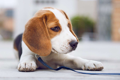

In [27]:
from PIL import Image as disp_image
from IPython.display import display

for image_path in images:
    image = disp_image.open(image_path)
    image.thumbnail((120, 120))  # Resize the image in place
    display(image)  # Display the resized image

None